In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from online_training import *
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

In [24]:
#Parámetros

BASE_PATH = 'C:/Users/Richard/Desktop/Entorno Tesis/'
PATH = os.path.join(BASE_PATH, 'data/DogFaceNet_224resized/after_4_bis/')       # Ruta a imágenes
PATH_SAVE = os.path.join(BASE_PATH, 'output/history/')
PATH_MODEL = os.path.join(BASE_PATH, 'output/model/')

# Crear directorios si no existen
os.makedirs(PATH_SAVE, exist_ok=True)
os.makedirs(PATH_MODEL, exist_ok=True)

SIZE = (224, 224, 3)                           # Tamaño de entrada
TEST_SPLIT = 0.1                                # Proporción test

# Configuración de entrenamiento
LOAD_NET = False                                # Cargar modelo existente?
NET_NAME = 'dogfacenet.colab'                   # Nombre del modelo
START_EPOCH = 0                                 # Época inicial
NBOF_EPOCHS = 70                               # Épocas (reducido para prueba)
HIGH_LEVEL = True                               # Usar high-level
STEPS_PER_EPOCH = 50                           # Pasos por época
VALIDATION_STEPS = 30                           # Pasos de validación

In [25]:
#Carga del dataset

print(PATH)

assert os.path.isdir(PATH), '[Error] El PATH del dataset no existe.'

print('Cargando dataset...')

# Rápido
filenames_list = []
labels_list = []
idx = 0
for root, dirs, files in os.walk(PATH):
    if len(files) > 1:
        for file in files:
            filenames_list.append(os.path.join(root, file).replace('\\', '/')) # Estandarizar separador
        labels_list.extend([idx] * len(files))
        idx += 1

filenames = np.array(filenames_list)
labels = np.array(labels_list)

print('Completado.')

print('Número total de imágenes: {:d}'.format(len(labels)))

nbof_classes = len(np.unique(labels))
print('Número total de clases: {:d}'.format(nbof_classes))

C:/Users/Richard/Desktop/Entorno Tesis/data/DogFaceNet_224resized/after_4_bis/
Cargando dataset...
Completado.
Número total de imágenes: 8363
Número total de clases: 1393


In [26]:
# División train/test

nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

filenames_test = filenames[keep_test]
labels_test = labels[keep_test]

filenames_train = filenames[keep_train]
labels_train = labels[keep_train]

print("Número de datos de entrenamiento: " + str(len(filenames_train)))
print("Número de clases de entrenamiento: " + str(nbof_classes-nbof_test))
print("Número de datos de testeo: " + str(len(filenames_test)))
print("Número de clases de testeo: " + str(nbof_test))

Número de datos de entrenamiento: 7666
Número de clases de entrenamiento: 1254
Número de datos de testeo: 697
Número de clases de testeo: 139


In [27]:
#Funciones de Perdida

alpha = 0.3
def triplet(y_true,y_pred):

    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]

    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

#Métrica de validación

def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]

    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.less(ap+alpha,an)

In [28]:
#Modelo
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip

if LOAD_NET:
    print(f'Loading model from {PATH_MODEL}{NET_NAME}.{START_EPOCH}.h5 ...')
    model = tf.keras.models.load_model(
        f'{PATH_MODEL}{NET_NAME}.{START_EPOCH}.h5',
        custom_objects={'triplet':triplet,'triplet_acc':triplet_acc}
    )
    print('Done.')
else:
    print(f'Defining model {NET_NAME} ...')

    emb_size = 64
    
    # --- OPTIMIZACIÓN: Capas de Aumento de Datos (en GPU) ---
    data_augmentation_layers = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.08), # Equivalente a rotation_range=8
        RandomZoom(0.1),      # Equivalente a zoom_range=0.1
    ], name='data_augmentation')

    inputs = Input(shape=SIZE)
    
    # Aplicar aumento en la GPU
    x = data_augmentation_layers(inputs)

    x = Conv2D(16, (7, 7), (2, 2), use_bias=False, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3))(x)

    # --- ARREGLO: Bucle 'for' corregido ---
    for filters in [16,32,64,128,512]: # <-- 'layer' cambiado a 'filters'
    # Capa de proyección para igualar dimensiones y hacer downsampling
        residual = Conv2D(filters, (1, 1), strides=(2,2), padding='same', use_bias=False)(x)
        residual = BatchNormalization()(residual)

        # --- Primer bloque residual ---
        x = Conv2D(filters, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = Conv2D(filters, (3, 3), use_bias=False, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, residual]) # Añadir la conexión residual

        # --- Segundo bloque residual ---
        residual_2 = x # Guardar la salida del bloque anterior
        x = Conv2D(filters, (3, 3), use_bias=False, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, residual_2])

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(emb_size, use_bias=False)(x)
    outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

    model = tf.keras.Model(inputs,outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(loss=triplet,
                optimizer=optimizer,
                metrics=[triplet_acc])

    print('Done.')

print(model.summary())

Defining model dogfacenet.colab ...
Done.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 112, 112,  │      2,352 │ data_augmentatio… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 19, 19,    │      2,304 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 19, 19,    │      2,304 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 19, 19,    │        256 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 19, 19,    │      2,304 │ add_10[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │         64 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 10, 10,    │      4,608 │ add_11[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        128 │ conv2d_27[0][0] 

 Total params: 5,922,928 (22.59 MB)

 Trainable params: 5,916,880 (22.57 MB)

 Non-trainable params: 6,048 (23.62 KB)

None


In [22]:
#Entrenamiento
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import math

# --- OPTIMIZACIÓN: Callback para generar Embeddings ---
# Esta clase recalculará los embeddings 1 VEZ POR ÉPOCA, no en cada lote.
class EmbeddingGeneratorCallback(Callback):
    def __init__(self, filenames, labels, batch_size, nbof_subclasses):
        super().__init__()
        self.filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        self.nbof_subclasses = nbof_subclasses
        self.crt_loss = 0.6 # Pérdida inicial (como tenías)
        
        print("Generando embeddings iniciales...")
        # Generamos los primeros embeddings antes de entrenar
        self.predicts = self.model.predict(
            predict_generator(self.filenames, self.batch_size),
            steps=math.ceil(len(self.filenames) / self.batch_size),
            verbose=1
        )

    def on_epoch_begin(self, epoch, logs=None):
        # 1. Actualizar embeddings ANTES de que comience la nueva época
        print(f"\nÉpoca {epoch+1}: Generando nuevos embeddings para hard mining...")
        self.predicts = self.model.predict(
            predict_generator(self.filenames, self.batch_size),
            steps=math.ceil(len(self.filenames) / self.batch_size),
            verbose=1
        )
        
        # 2. Crear el generador de entrenamiento para ESTA época
        #    Le pasamos los embeddings frescos y la última pérdida
        print(f"Usando pérdida de la época anterior: {self.crt_loss:.4f}")
        self.model.train_generator = online_adaptive_hard_image_generator(
            self.filenames,
            self.labels,
            self.predicts, # <-- ¡Aquí pasamos los embeddings!
            self.crt_loss,
            self.batch_size,
            use_aug=False # El aumento ya está en el modelo
        )

    def on_epoch_end(self, epoch, logs=None):
        # 3. Guardar la pérdida de la época que acaba de terminar
        #    para usarla en la PRÓXIMA época (en on_epoch_begin)
        if logs and 'loss' in logs:
            self.crt_loss = logs['loss']

# --- Configuración del entrenamiento ---
batch_size = 63
nbof_subclasses = 40 # Esta variable ya no se usa en el generador modificado, pero la dejamos

# Crear directorios
os.makedirs(PATH_MODEL, exist_ok=True)
os.makedirs(PATH_SAVE, exist_ok=True)

# --- ARREGLO: Callback de Checkpoint con nombre de archivo corregido ---
# Guardará el mejor modelo basado en la precisión de validación
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(PATH_MODEL, f"{NET_NAME}.best_val_acc.keras"), # <-- Nombre fijo para "el mejor"
    monitor="val_triplet_acc",
    mode="max",
    save_best_only=True,
    verbose=1
)

# Callback para guardar el modelo al final de CADA época (opcional)
# filepath usa 'epoch' (variable de Keras), no 'i'
epoch_save_callback = ModelCheckpoint(
    filepath=os.path.join(PATH_MODEL, f"{NET_NAME}.epoch{{epoch:02d}}.keras"), # <-- Keras reemplazará {epoch}
    save_weights_only=False,
    verbose=1
)


# --- OPTIMIZACIÓN: Callback de Embeddings ---
embedding_callback = EmbeddingGeneratorCallback(
    filenames_train,
    labels_train,
    batch_size,
    nbof_subclasses
)

# --- OPTIMIZACIÓN: Generador de Validación ---
# (Usando 'image_generator' (soft) como tenías. Ver optimización 4 para una mejor alternativa)
validation_gen = image_generator(
    filenames_test, 
    labels_test, 
    batch_size, 
    use_aug=False
)

# --- OPTIMIZACIÓN: Bucle 'for' reemplazado por model.fit() ---
print("Iniciando entrenamiento...")

# El 'train_generator' se crea dinámicamente por el 'embedding_callback'
history = model.fit(
    embedding_callback.model.train_generator, # El callback lo crea
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=NBOF_EPOCHS,
    initial_epoch=START_EPOCH,
    validation_data=validation_gen,
    validation_steps=VALIDATION_STEPS,
    callbacks=[
        checkpoint_callback,    # Guarda el mejor
        epoch_save_callback,    # Guarda cada época
        embedding_callback      # Actualiza embeddings
    ]
)

# --- OPTIMIZACIÓN: Guardar historial UNA VEZ al final ---
print("Entrenamiento completado. Guardando historial...")
history_data = np.array([
    history.history['loss'],
    history.history['val_loss'],
    history.history['triplet_acc'],
    history.history['val_triplet_acc']
])
np.save(os.path.join(PATH_SAVE, f'{NET_NAME}.final_history.npy'), history_data)

print("Historial guardado.")

Generando embeddings iniciales...


AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
#history_ = np.load(PATH_SAVE+'dogfacenet.colab.74.npy')

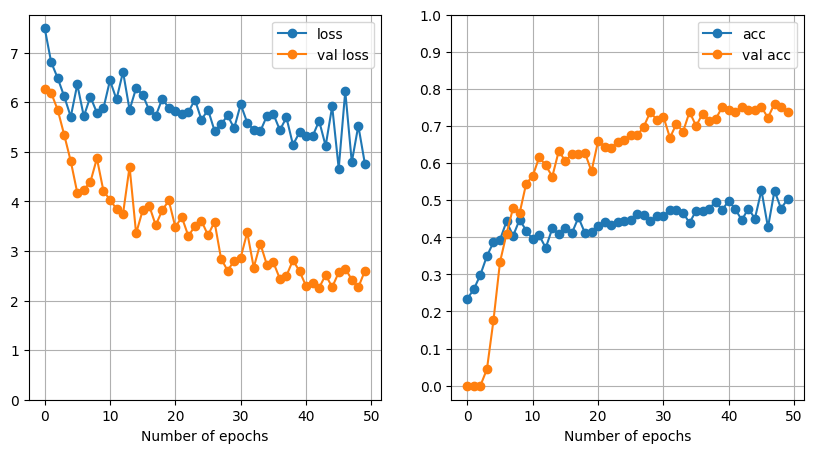

In [ ]:
loss,val_loss,acc,val_acc = history_

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()

Evaluación Verificación

In [ ]:
# Verification task, create pairs

print('Verification task, pairs creation...')

NBOF_PAIRS = 5000
#NBOF_PAIRS = len(images_test)

# Create pairs
h,w,c = SIZE
pairs = []
issame = np.empty(NBOF_PAIRS)
class_test = np.unique(labels_test)
for i in range(NBOF_PAIRS):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Choose classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = filenames_test[np.equal(labels_test,class1)]
        images_class2 = filenames_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs = pairs + [images_class1[np.random.randint(len(images_class1))]]
        pairs = pairs + [images_class2[np.random.randint(len(images_class2))]]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Choose a class
        clas = np.random.randint(len(class_test))
        images_class = filenames_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs = pairs + [images_class[idx_image1]]
        pairs = pairs + [images_class[idx_image2]]
        issame[i] = 1

print('Done.')

Verification task, pairs creation...
Done.


Verification task, model evaluation...
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step
Done.
Best threshold: 1.523
Best accuracy: 0.7884
Ground truth: [0. 1. 1. 0. 0.]


IndexError: list index out of range

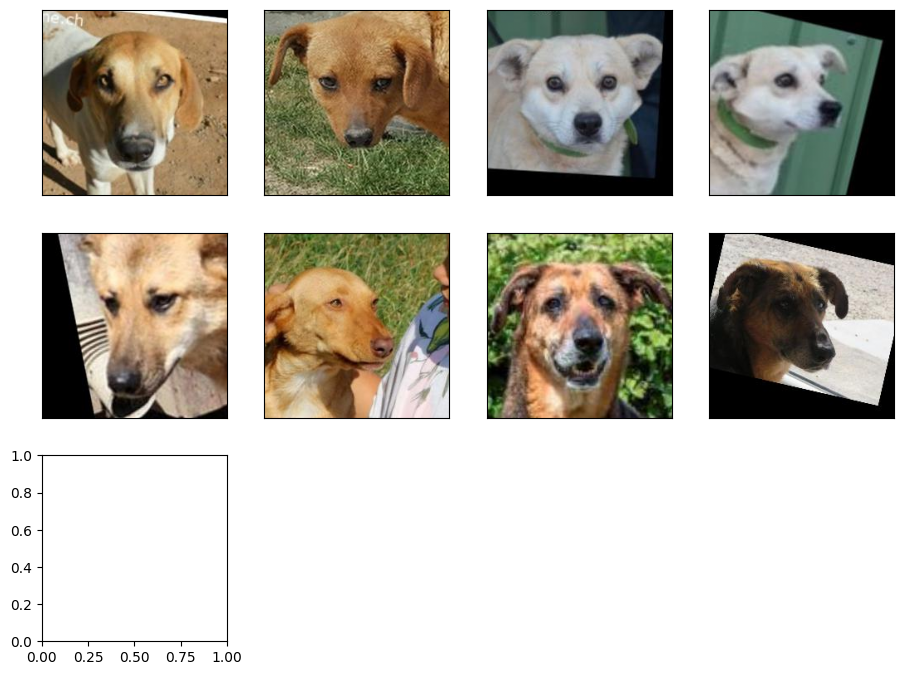

In [ ]:
# Verification task, evaluate the pairs

print('Verification task, model evaluation...')

predict=model.predict(predict_generator(pairs, 32), steps=int(np.ceil(len(pairs)/32)))
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

best = 0
best_t = 0
thresholds = np.arange(0.001,4,0.001)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print('Done.')
print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

# Test: Look at wrong pairs
t = 0.68
fa = []
fr = []
for i in range(len(dist)):
    # false accepted
    if issame[i] == 0 and dist[i]<t:
        fa += [i]
    # false rejected
    if issame[i] == 1 and dist[i]>t:
        fr += [i]

s = 10
sr = 20
n = 5
print('Ground truth: {:s}'.format(str(issame[s:(n+s)])))
fig = plt.figure(figsize=(11,2.8*n))
for i in range(s,s+n):
    # AÑADIR ESTA COMPROBACIÓN
    if i < len(fa) and (i + sr - s) < len(fr):
        fa_idx = fa[i]
        fr_idx = fr[i+sr-s]

        # False accepted: columns 1 and 2
        plt.subplot(n,4,4*(i-s)+1)
        plt.imshow(load_images([pairs[2*fa_idx]])[0]) # Usar fa_idx
        plt.xticks([])
        plt.yticks([])
        plt.subplot(n,4,4*(i-s)+2)
        plt.imshow(load_images([pairs[2*fa_idx+1]])[0]) # Usar fa_idx
        plt.xticks([])
        plt.yticks([])

        # False rejected: columns 3 and 4
        plt.subplot(n,4,4*(i-s)+3)
        plt.imshow(load_images([pairs[2*fr_idx]])[0]) # Usar fr_idx
        plt.xticks([])
        plt.yticks([])
        plt.subplot(n,4,4*(i-s)+4)
        plt.imshow(load_images([pairs[2*fr_idx+1]])[0]) # Usar fr_idx
        plt.xticks([])
        plt.yticks([])
    else:
        print(f"Advertencia: No hay suficientes errores para mostrar en el índice {i}")
        break

plt.show()

threshold = 0.3
less = np.less(dist, threshold)
acc = np.logical_not(np.logical_xor(less, issame))
acc = acc.astype(float)
out = np.sum(acc)
out = out/len(acc)

print("Accuracy: " + str(out))

Evaluación Reidentificación